In [2]:
%matplotlib ipympl

ValueError: Key backend: 'ipympl' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
from time import time

from matplotlib import pyplot as plt, dates as mdates

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.svm import OneClassSVM
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL

<Axes: xlabel='ts'>

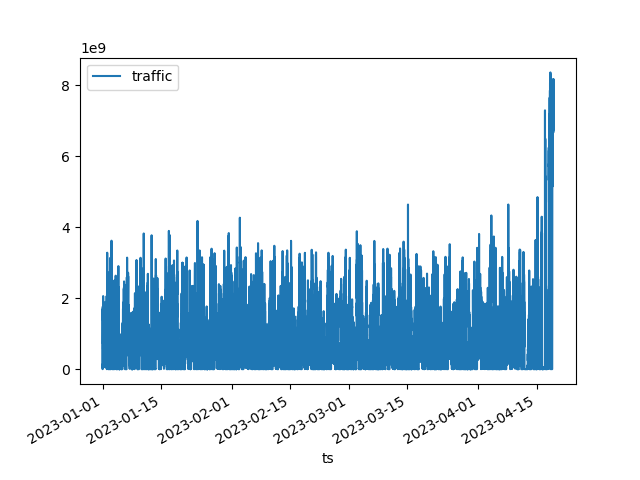

In [4]:
# LOAD, FILTER AND PLOT DATASET

df = pd.read_csv("data/1_8_out.csv", index_col=0)

df = df[(df["ts"] >= "2023-01-01")&(df["ts"] <= "2023-04-19")]

df["ts"] = pd.to_datetime(df["ts"])
df.plot(x="ts", y="traffic")

<Axes: xlabel='ts', ylabel='traffic_scaled'>

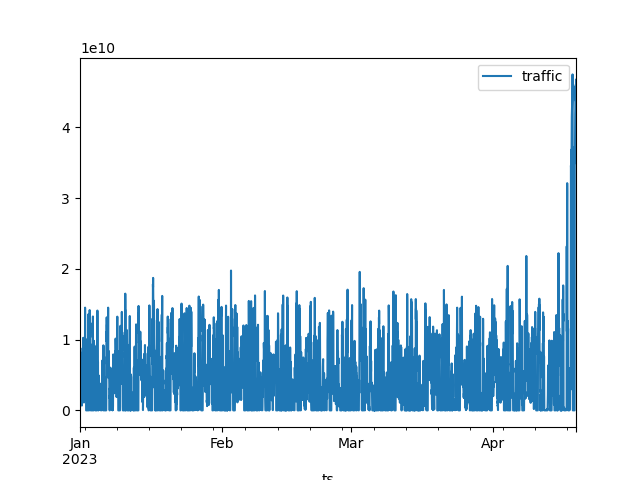

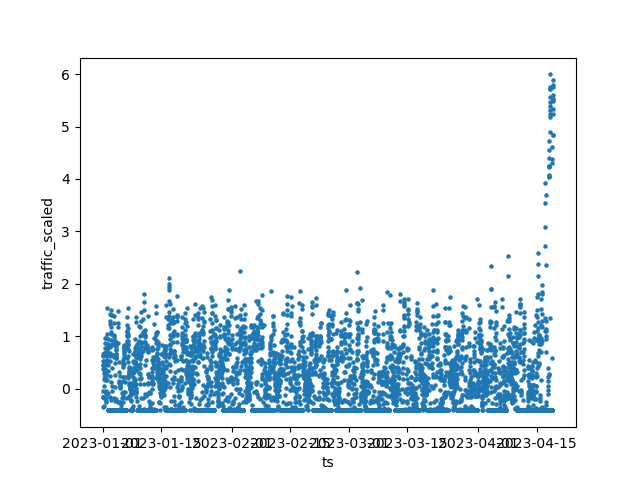

In [5]:
#PREPROCESSING

SAMPLING_BUCKET = 30
WIN_SIZE = 7
MAX_ZSCORE = 2
OUTPUT = "data/ds_prep.csv"

# FILLING MISSING VALUES
df = df.fillna(0.0)

# RESAMPLING
df = df.resample(timedelta(minutes=SAMPLING_BUCKET), on="ts").sum()

# OUTLIERS REMOVAL (Z SCORE)
df["mean"] = df["traffic"].rolling(window=WIN_SIZE, center=True, min_periods=1).mean()
df["std"] = df["traffic"].rolling(window=WIN_SIZE, center=True, min_periods=1).std()
df["zscore"] = np.abs((df["traffic"] - df["mean"]) / df["std"])
df.loc[df["zscore"] > MAX_ZSCORE, "traffic"] = 0
df = df[["traffic"]]

# scaling
scaler = RobustScaler()
df['traffic_scaled'] = scaler.fit_transform(df['traffic'].values.reshape(-1, 1))

# adding features
df.loc[:, "hour"] = df.index.hour
df.loc[:, "week_day"] = df.index.dayofweek
# prep_data: ts, traffic, traffic_scaled, hour, week_day

df.to_csv(OUTPUT)

df_ri = df.reset_index()
df_ri.plot(x="ts", y="traffic")
df_ri.plot.scatter(x="ts", y="traffic_scaled", s=5)

In [6]:
# A COUPLE OF HELPER METHODS TO PLOT RESULTS

def plot_anomalies(title, data):
    # data: (traffic_scaled, [ts, predictions, anomaly, green_band])
    x = data["ts"] if "ts" in data else pd.to_datetime(data.index)

    fig = plt.figure(figsize=(12, 6))
    plt.plot(x, data["traffic_scaled"], color="blue", label='Real Traffic', linewidth=1)

    if "predictions" in data and "green_band" not in data:
        plt.plot(x, data["predictions"], color="black", label='Predicted Traffic', linewidth=1)

    if "green_band" in data:
        plt.fill_between(x, data["green_band"], 1, step="pre", alpha=0.4, color="green", label="Threshold Traffic")

    plt.legend()

    if "anomaly" in data:
        data.loc[:, ["group"]] = (data["anomaly"].diff(1) != 0).astype('int').cumsum()
        group_sizes = data.groupby(["group"]).size()
        anomaly_groups = group_sizes.index[group_sizes >= 4].tolist()
        data["color"] = "blue"
        data.loc[data["anomaly"] > 0, "color"] = "yellow"
        for ag in anomaly_groups:
            if data.loc[data["group"] == ag].iloc[0]["anomaly"]:
                data.loc[data["group"] == ag, "color"] = "red"
        anomalies_data = data.loc[data["anomaly"] > 0]
        x = pd.to_datetime(anomalies_data.index)
        plt.scatter(x, anomalies_data["traffic_scaled"], s=20, c=anomalies_data["color"])

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Traffic (Scaled)')
    fig.tight_layout()
    plt.show()

def plot_score(title, df):
    fig = plt.figure(figsize=(14, 6))
    x = pd.to_datetime(df.index)

    plt.plot(x, df["traffic_scaled"], label='Traffic Scaled', color='blue', linewidth=1)
    plt.scatter(x, df["traffic_scaled"], s=20, c=df["anomaly_score"], cmap="plasma")

    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Traffic Scaled')
    plt.title(title)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.colorbar()
    plt.show()

STL done in: 0.824s


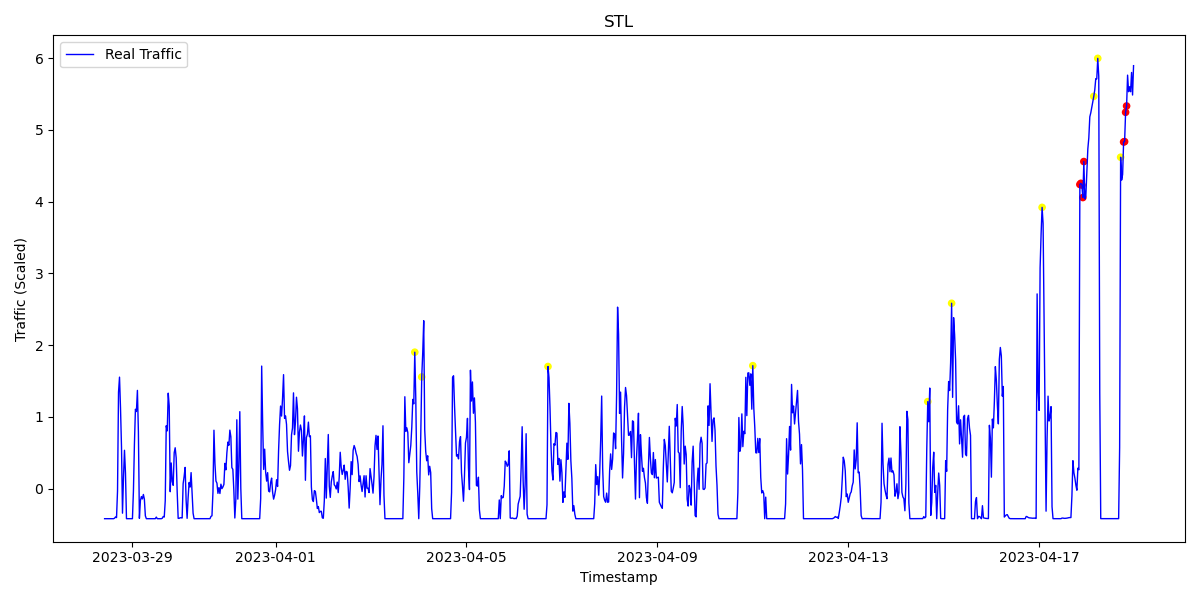

In [7]:
# STL

def stl(prep_ds_path):
    df = pd.read_csv(prep_ds_path, index_col=0)
    t = time()

    model = STL(df['traffic_scaled'], period=48)
    res = model.fit()
    df["resid"] = res.resid
    df = df.tail(int(df.shape[0] * 0.2))
    df["anomaly"] = (df["resid"] > 1.0)

    print(f"STL done in: {round(time() - t, 3)}s")
    plot_anomalies("STL", df)

stl("data/ds_prep.csv")

C:\Users\loren\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\loren\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\loren\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Sarimax done in: 21.517s


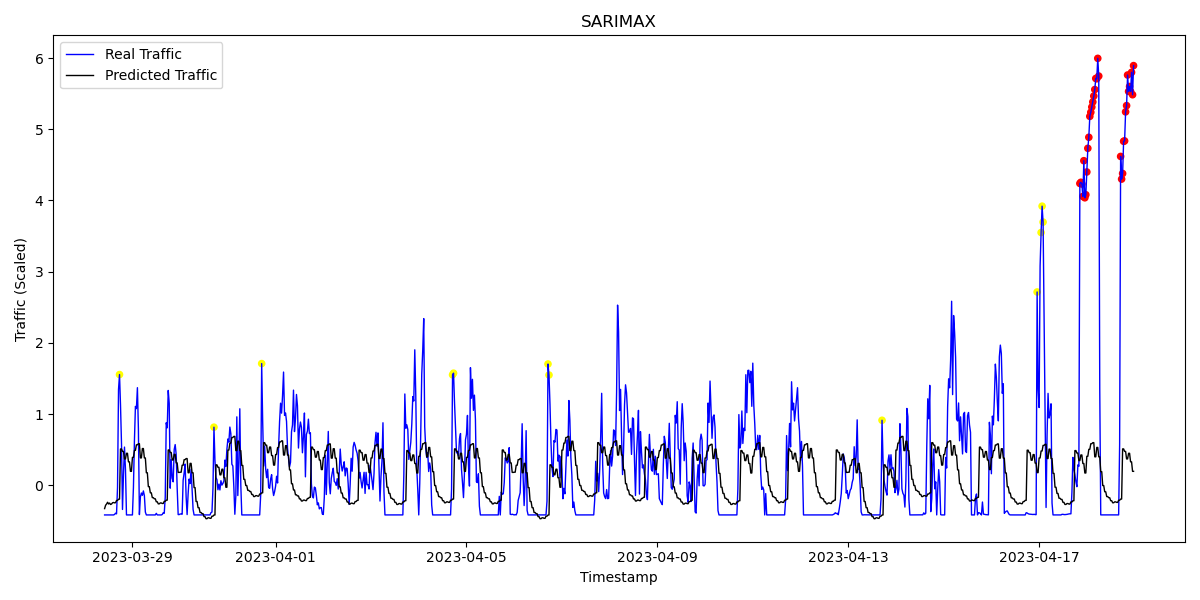

In [8]:
# SARIMAX

def sarimax(prep_ds_path):
    df = pd.read_csv(prep_ds_path, index_col=0)
    t = time()

    y = df['traffic_scaled']
    exog = pd.get_dummies(df[['week_day', 'hour']], columns=['week_day', 'hour'])

    train_size = int(len(y) * 0.8)
    train_y, test_y = y[:train_size], y[train_size:]
    train_exog, test_exog = exog[:train_size], exog[train_size:]

    model = SARIMAX(endog=train_y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 48*7), exog=train_exog)
    model = model.fit()

    df = df.tail(int(df.shape[0] * 0.2))
    df["predictions"] = model.predict(
        start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_exog, dynamic=True
    )
    df["anomaly"] = ((df["traffic_scaled"]+1) >= 3*(df["predictions"]+1))

    print(f"Sarimax done in: {round(time() - t, 3)}s")
    plot_anomalies("SARIMAX", df)

sarimax("data/ds_prep.csv")

Random Forest done in: 1.206s


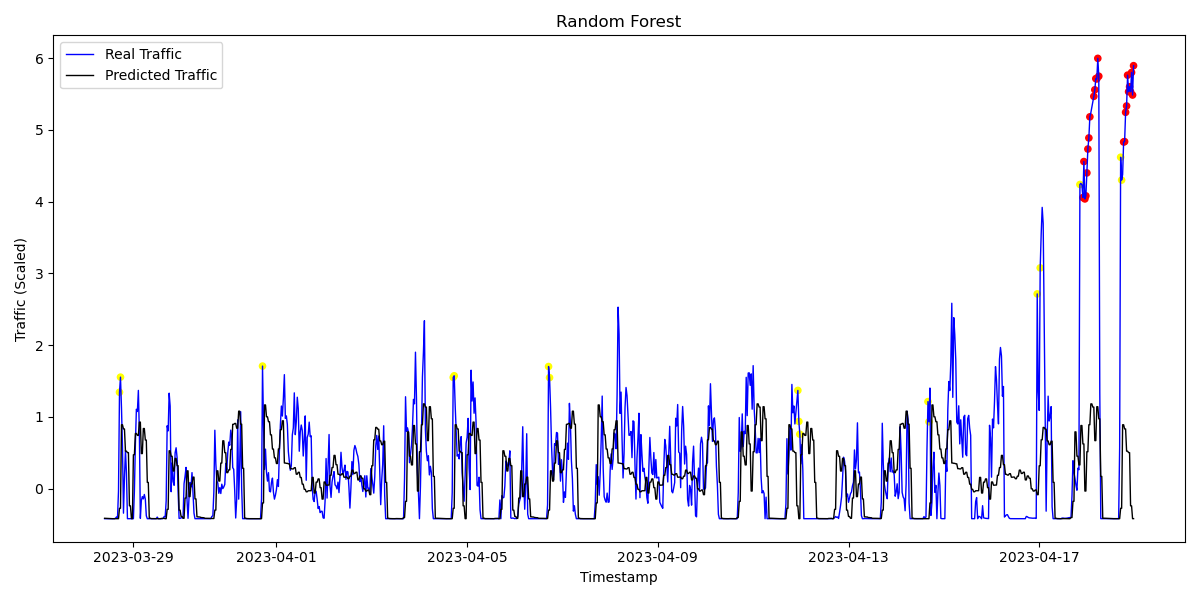

In [10]:
# RANDOM FOREST

def random_forest(prep_ds_path):
    df = pd.read_csv(prep_ds_path, index_col=0)
    t = time()

    x = df[['hour', 'week_day']]
    y = df['traffic_scaled']
    train_size = int(len(y) * 0.8)
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = RandomForestRegressor(n_estimators=300)
    model = model.fit(x_train, y_train)

    df = df.tail(len(y)-train_size)
    df["predictions"] = model.predict(x_test)
    df["anomaly"] = ((df["traffic_scaled"] + 1) >= 3 * (df["predictions"] + 1))

    print(f"Random Forest done in: {round(time() - t, 3)}s")
    plot_anomalies("Random Forest", df)

random_forest("data/ds_prep.csv")

Isolation Forest done in: 2.697s


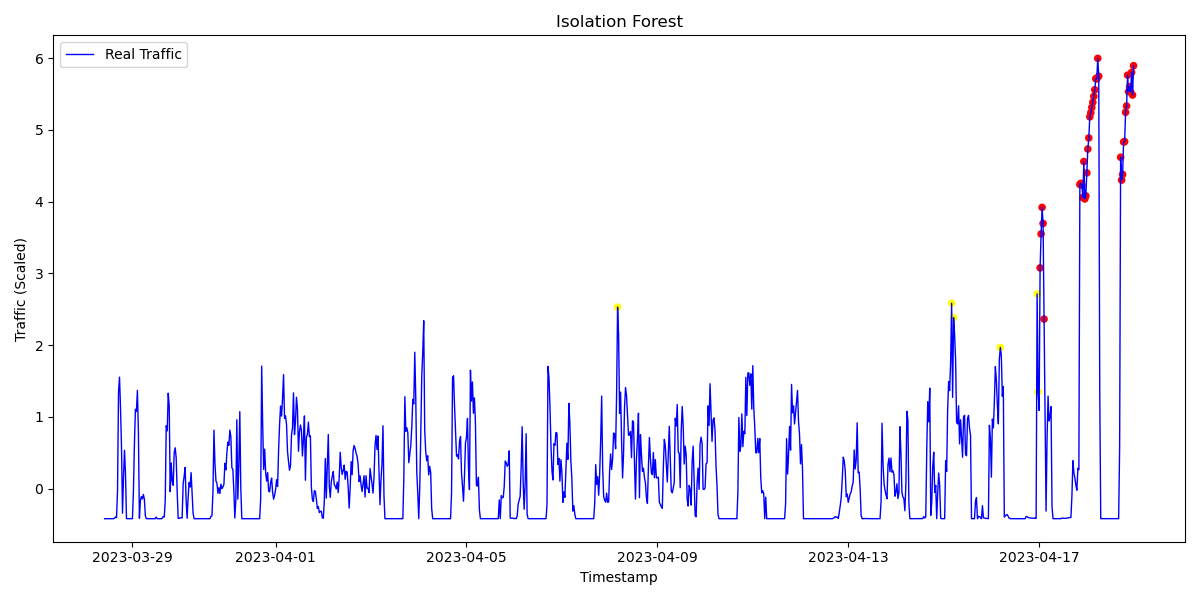

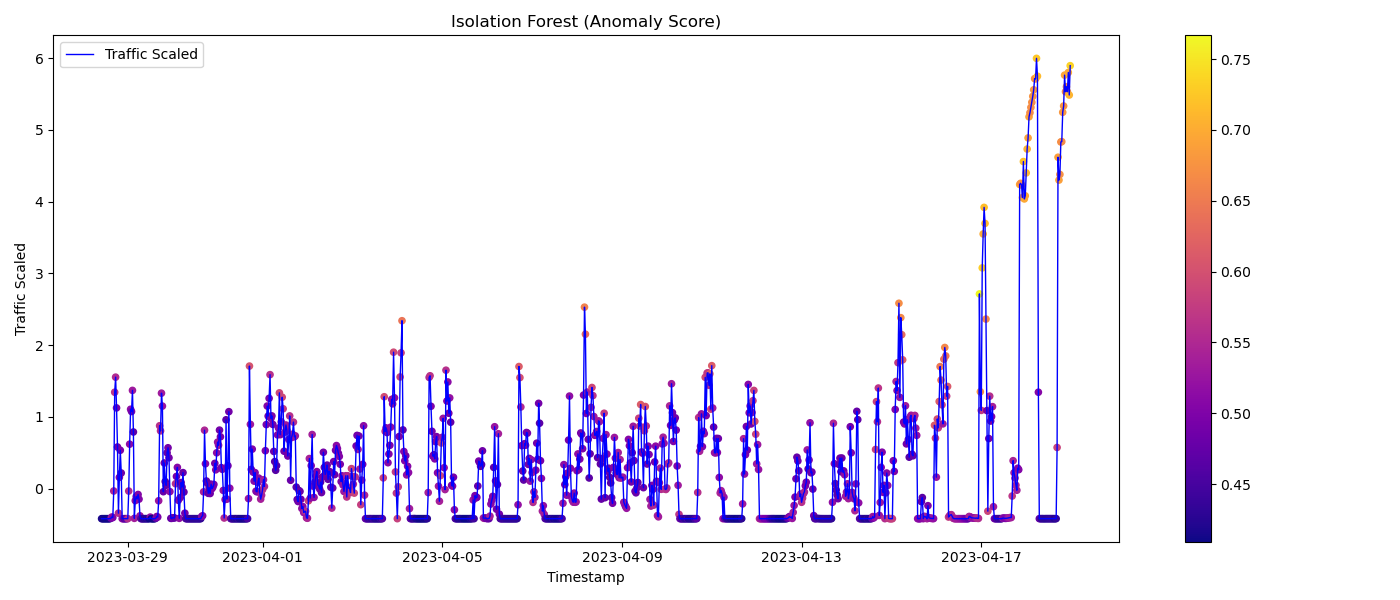

In [11]:
# ISOLATION FOREST

def isolation_forest(prep_ds_path):
    data = pd.read_csv(prep_ds_path, index_col=0)
    t = time()
    
    model_input = np.reshape(np.array(data[["traffic_scaled", "hour", "week_day"]]), (data.shape[0], 3))
    model = IsolationForest(
        max_samples=model_input.shape[0],
        max_features=model_input.shape[1],
        n_estimators=500
    )
    model.fit(model_input)
    
    data["anomaly_score"] = model.score_samples(model_input) * (-1)
    data["anomaly"] = data["anomaly_score"] >= 0.65
    print(f"Isolation Forest done in: {round(time() - t, 3)}s")
    
    data = data.tail(int(data.shape[0] * 0.2))
    plot_anomalies("Isolation Forest", data)
    plot_score("Isolation Forest (Anomaly Score)", data)

isolation_forest("data/ds_prep.csv")

SVM done in: 3.105s


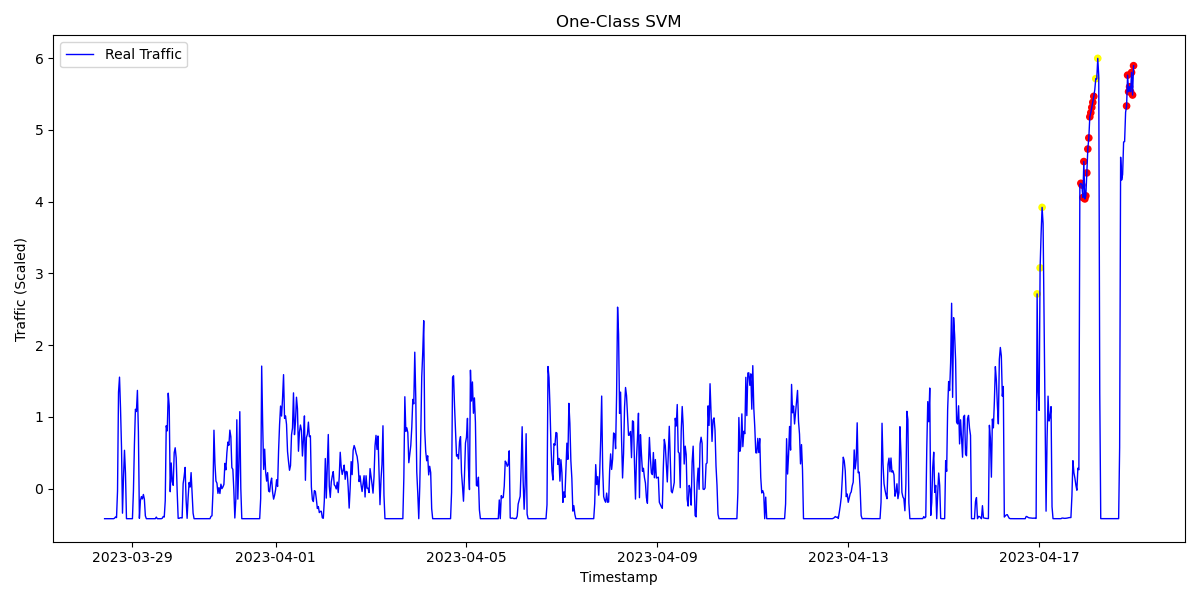

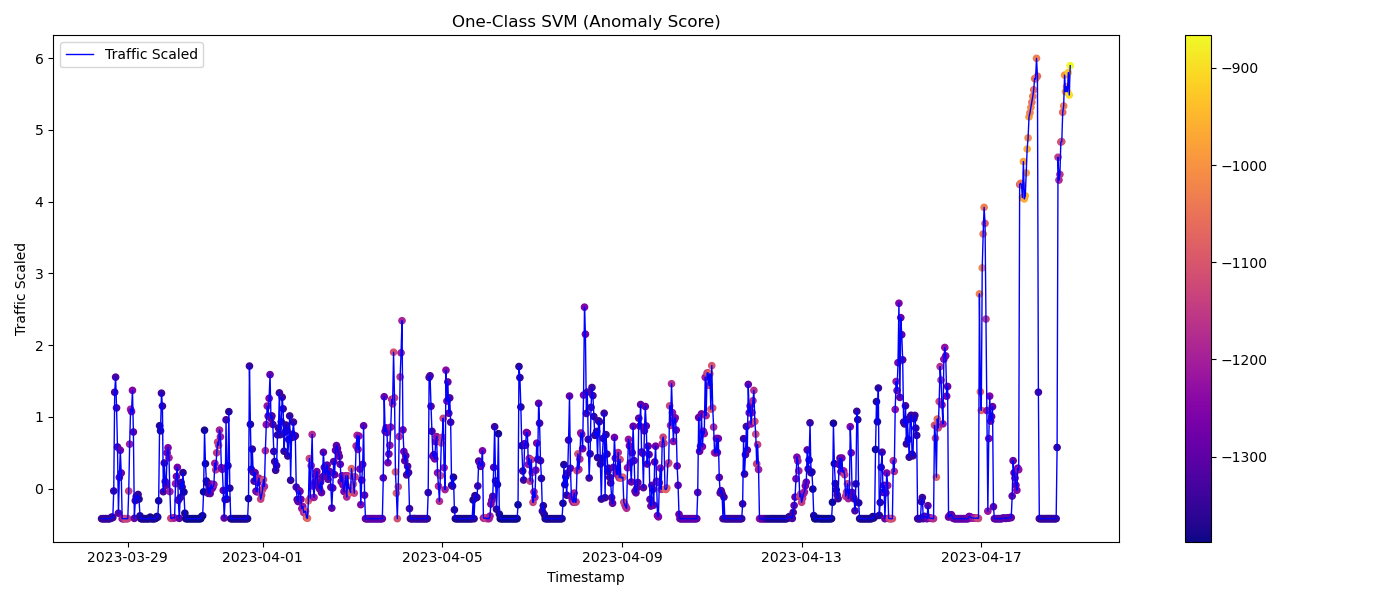

In [12]:
# ONE-CLASS SVM

def svm(prep_ds_path):
    data = pd.read_csv(prep_ds_path, index_col=0)
    t = time()

    model_input = np.reshape(np.array(data[["traffic_scaled", "hour", "week_day"]]), (data.shape[0], 3))
    model = OneClassSVM()
    model.fit(model_input)

    data["anomaly_score"] = model.score_samples(model_input) * (-1)
    data["anomaly"] = data["anomaly_score"] >= -1050
    data = data.tail(int(data.shape[0] * 0.2))

    print(f"SVM done in: {round(time() - t, 3)}s")
    plot_anomalies("One-Class SVM", data)
    plot_score("One-Class SVM (Anomaly Score)", data)

svm("data/ds_prep.csv")

Random Forest done in: 1.16s


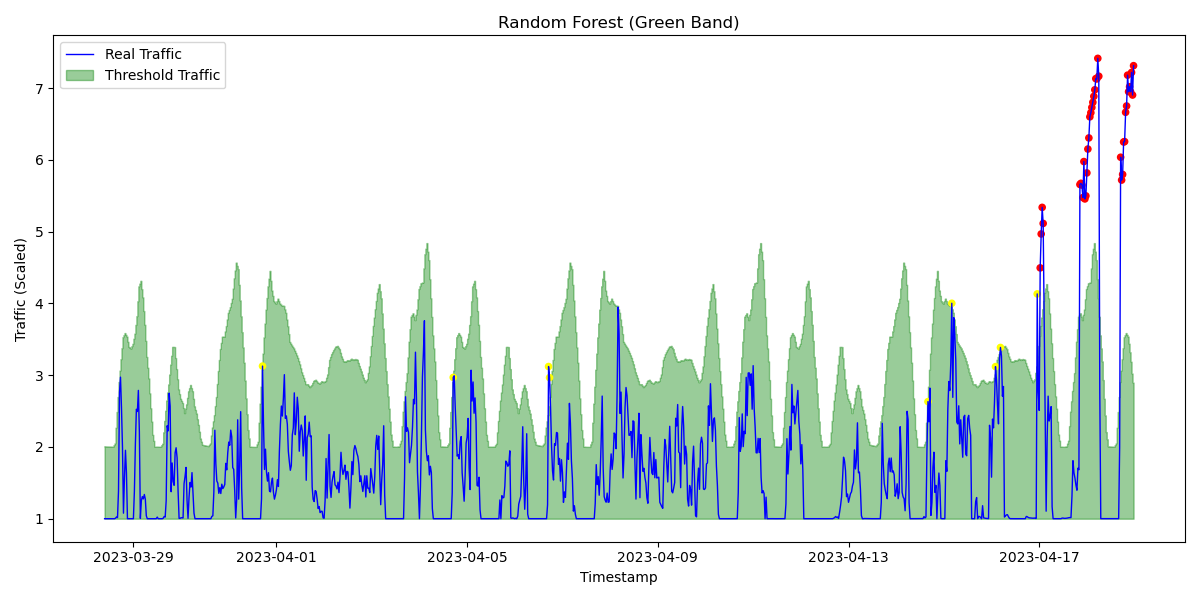

In [13]:
# GREEN BAND ON RANDOM FOREST

def random_forest_green_band(prep_ds_path):
    df = pd.read_csv(prep_ds_path, index_col=0)
    t = time()

    x = df[['hour', 'week_day']]
    y = df['traffic_scaled']
    train_size = int(len(y) * 0.8)
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = RandomForestRegressor(n_estimators=300)
    model = model.fit(x_train, y_train)

    df = df.tail(len(y)-train_size)
    df["predictions"] = model.predict(x_test)

    # Compute green band
    min_value = abs(min(df["predictions"].min(), df["traffic_scaled"].min()))
    df["predictions"] += (min_value + 1)
    df["traffic_scaled"] += (min_value + 1)
    df["green_band"] = 2.0 * df["predictions"]
    df["green_band"] = df["green_band"].rolling(window=12, center=True, min_periods=0).mean()
    df["anomaly"] = df["traffic_scaled"] > df["green_band"]

    print(f"Random Forest done in: {round(time() - t, 3)}s")
    plot_anomalies("Random Forest (Green Band)", df)

random_forest_green_band("data/ds_prep.csv")